In [1]:
import os
path = os.path.abspath(os.getcwd())
print(path)
folder = os.path.split(path)[-1]
if folder == 'Subjects_Scripts':
    print('Subjects_Scripts')
    %run my_imports.py
elif folder == 'MySpaces':
    print('MySpaces')
    %run Subjects_Scripts/my_imports.py

C:\Users\bastien\Documents\Git\python_analysis_2\project\MySpaces\Subjects_Scripts
Subjects_Scripts


In [2]:
# folderSubject = r'D:\DataSet\MySpaces\data\s06'

In [3]:
folderName = os.path.join(folderSubject,'records','fif','agency')

raws_list,events = load_fif_from_folder(folderName,concatFile=False)

raws = mne.concatenate_raws(raws_list)
events = mne.find_events(raws, stim_channel='TRIGGER', shortest_event = 1)
montageFile = os.path.join(folderAnalysis,'locFile','montageANT64_inverse.txt')
layoutFile  = os.path.join(folderAnalysis,'locFile','antneuro_64ch.lay')
chan_dict_file = os.path.join(folderAnalysis,'locfile','chan_dict_64ANT.txt')

f = open(chan_dict_file,'r')
chan_dict = eval(f.read())
     
cfg= {'spatial_filter': 'CAR',
'montage_file':montageFile,
'layout_file':layoutFile}

scale = dict(mag=1e-12, grad=4e-11, eeg=100, eog=150, ecg=500,
     emg=1e3, ref_meg=1e-12, misc=1e-3, stim=1,
     resp=1e3, chpi=1e-4, whitened=1e2)

print(raws.ch_names)

if 'AUX3' in raws.ch_names:
    print("1")
    resp_channel = "AUX3"
    mapping_channel_type = {'TRIGGER':'stim','EOG':'eog','AUX1':'ecg','AUX3':'resp','M1':'emg','M2':'emg'}
elif 'AUX7' in raws.ch_names:
    print("2")
    resp_channel = "AUX7"
    mapping_channel_type = {'TRIGGER':'stim','EOG':'eog','AUX1':'ecg','AUX7':'resp','M1':'emg','M2':'emg'}
elif 'AUX13' in raws.ch_names:
    print("3")
    resp_channel = "AUX13"
    mapping_channel_type = {'TRIGGER':'stim','EOG':'eog','AUX1':'ecg','AUX13':'resp','M1':'emg','M2':'emg'}


raws.set_channel_types(mapping_channel_type)
raws = set_montage_from_file(raws,cfg,kind='topomap')

print('[Preprocessing] Preprocessed Data')

print('[Events Visualization] Checking events')
print(np.unique(events[:,2]))
print('[Events Visualization] Define dictionary for epoching')

[Load Data] Found 5 files
['TRIGGER', 'FP1', 'FPZ', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'CZ', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'PZ', 'P4', 'P8', 'POZ', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCZ', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'OZ', 'AUX1', 'AUX7']
2
[Preprocessing] Preprocessed Data
[Events Visualization] Checking events
[ 10  20  30  40  60  70  99 110 111 112 113 114 115 116 117 118 119]
[Events Visualization] Define dictionary for epoching


# Event Preprocessing

In [4]:
file = os.path.join(folderName,'pilot_logs.csv')
dataFrame = pd.read_csv(file,header=0)
dataFrame.head()

data_type_frame = dataFrame['trial_type']
data_type = data_type_frame.to_numpy()
data_type = (data_type != 'BMI').astype(int)+1
print(np.shape(data_type))

list_Type_trials = dict(cue=2,self=1)
print(list_Type_trials)

(300,)
{'cue': 2, 'self': 1}


In [5]:
idx_data_action = np.where(events[:,2] == 30)[0]
trial_remove = []
trialIdx = []
for i,idx_Start in enumerate(idx_data_action):
    if events[idx_Start + 1,2] == 40:
        pass
    else:
        trialIdx.append(i)
        trial_remove.append(idx_Start)
        events[idx_Start-1:idx_Start+2,2] = 0
        
print(trialIdx,trial_remove)

[82, 84, 91, 114, 146, 155, 164, 196, 232, 246, 251, 261, 266, 273, 281] [498, 508, 550, 686, 878, 932, 984, 1176, 1392, 1476, 1504, 1562, 1590, 1632, 1678]


In [6]:
print(np.shape(data_type))
data_type = np.delete(data_type, trialIdx)
print(np.shape(data_type))

(300,)
(285,)


In [7]:
idx_action_event = np.where(events[:,2] == 40)[0]
idx_go_event = np.where(events[:,2] == 30)[0]
idx_start_event = np.where(events[:,2] == 20)[0]
print(len(idx_start_event),len(idx_go_event),len(idx_action_event))

285 285 285


In [8]:
for idx in range(len(idx_action_event)):
    if data_type[idx] == list_Type_trials['cue']:
        events[idx_action_event[idx],2] = 41
        events[idx_go_event[idx],2] = 31
        events[idx_start_event[idx],2] = 21
print('Trials splitted with events')

Trials splitted with events


# Respiration Preprocessing 

In [31]:
listEventOfInterest = {'ST_ACTION_SELF':40,'ST_ACTION_CUE':41}

# Amplitude
raw_filter = raws.copy()
picks_RESP = raw_filter.ch_names.index(resp_channel)
resp_data = np.squeeze(raw_filter.get_data(picks=picks_RESP))
sfreq = raw_filter.info['sfreq']
transient_change = mne.filter.filter_data(resp_data,sfreq=sfreq,l_freq=0.1,h_freq=10)
transient_change = np.reshape(transient_change, (-1, 1)).T 
info = mne.create_info(['AUX3filter'], raws.info['sfreq'], ['ecg'])
stim_raw = mne.io.RawArray(transient_change, info)
raw_filter.add_channels([stim_raw], force_update_info=True)

# Need to inverse that data because of ANTneuro
raw_filter._data = -1*raw_filter._data

epochs_amplitude_resp = mne.Epochs(raw_filter, events, event_id=listEventOfInterest,
                     tmin=-1, tmax=1,baseline=(None), preload = True)

# Phase
raw_hilb = raw_filter.copy()
picks_resp=raw_filter.ch_names.index("AUX3filter")
raw_hilb.apply_hilbert(picks_resp)
raw_phase = raw_hilb.copy()
raw_phase.apply_function(np.angle,picks_resp)

epochs_phase  = mne.Epochs(raw_phase, events, event_id=listEventOfInterest,
                         tmin=-2, tmax=2,baseline=None, preload = True)

print(epochs_phase)


<Epochs  |   285 events (all good), -2 - 2 sec, baseline off, ~606.1 MB, data loaded,
 'ST_ACTION_CUE': 200
 'ST_ACTION_SELF': 85>


# Loading ERD/S

In [10]:
var = os.path.join(folderSubject,'power_events')
power_events = pickle.load( open( var, "rb" ) ) 

In [14]:
channelsOfInterest = ['Fz',\
                      'FCz','FC1','FC2','FC3', 'FC4',\
                     'Cz','C1', 'C2','C3', 'C4',\
                      'CP1', 'CP2','CP3', 'CP4']

channelsOfInterest = ['FC3','C3','CP3']

print(channelsOfInterest)
picks_bandpower = mne.pick_channels(raws.ch_names,channelsOfInterest)
print(picks_bandpower)

['FC3', 'C3', 'CP3']
[15 41 48]


Mu
ST_ACTION_SELF
ST_ACTION_CUE
Beta
ST_ACTION_SELF
ST_ACTION_CUE


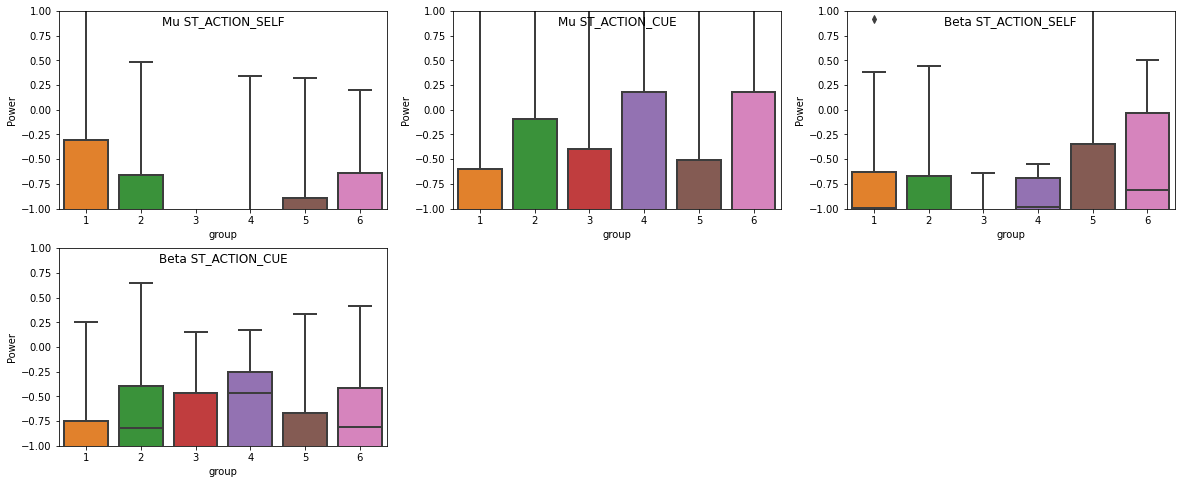

In [32]:
import seaborn as sns
import pandas as pd
from utils.utils_normalization import zscore_over_trials

fig = plt.figure(figsize=(20,8))
picks_respfiltered = raw_filter.ch_names.index("AUX3filter")
nbins = 7

df_events = dict()

iter_freqs = [
('Mu', 8, 12),
  ('Beta', 13, 29),
]


bins = np.linspace(-np.pi, np.pi, nbins)

nBand = len(iter_freqs)
iplot = 0

for band_name,fmin,fmax in iter_freqs:
    print(band_name)
    for iEvent,event_type in enumerate(listEventOfInterest):
        print(event_type)
        index_1 = np.where(power_events[event_type].times == 0)[0][0]
        
        iplot +=1
        # phase respiration
        data_resp_event = np.squeeze(epochs_phase[event_type].get_data(picks=picks_respfiltered)).real
        data_resp_event = data_resp_event[:,index_1]
        ind = np.digitize(data_resp_event, bins)
 
        # baseline + bandpower
        data_mu =power_events[event_type].copy().crop(fmin=fmin,fmax=fmax)
        data_mu = np.mean(np.mean(data_mu,axis=2),axis=1)
        data_mu = np.squeeze(data_mu[:,index_1])
        
        power_phase = []
        resp_phase = []
        df = pd.DataFrame()
        for iBin in range(nbins):
            a = data_mu * np.array(ind==iBin).astype(int)
            a[a==0] = np.nan
            power_phase.append(a)
        
        for iPhase,this_phase in enumerate(power_phase):
            pmu_trial = this_phase
            a = pd.DataFrame({ 'group' : np.repeat(iPhase,len(pmu_trial)), 'Power': pmu_trial})
            df = df.append(a)
        
        event_band_type = band_name + "_" + event_type
        df_events.update({event_band_type:df})
        
        # Plotting
        axs=fig.add_subplot(230+iplot)
        ax = sns.boxplot(x='group', y='Power', data=df,width=0.8,linewidth=2,showfliers = True)
        ax.set_title(event_band_type,y=0.9)
        axs.set_xlim([0.5,nbins-0.5])
        axs.set_ylim([-3,1])

# Saving Data


In [ ]:
saving_var('df_events_ACTION',folderSubject,df_events)